<h1 align='center'>Đỗ Trọng Khánh - 19521676<h1>

<h1 align='center'>Phân tích hành vi click với KMeans<h1>

##Bước 1: Cài đặt các thư viện cần thiết

In [ ]:
!pip install matplotlib==3.1.3
!pip install osmnet
!pip install folium

In [ ]:
!pip install rtree
!pip install pygeos
!pip install geojson
!pip install geopandas

In [ ]:
import geopandas as gpd
import numpy as np
import rtree
import matplotlib.pyplot as plt
import folium
import osmnet
import geojson
import pygeos
import pandas as pd

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


##Bước 2: Clone data

In [ ]:
!git clone https://github.com/CityScope/CSL_HCMC

Cloning into 'CSL_HCMC'...
remote: Enumerating objects: 1930, done.
remote: Counting objects: 100% (590/590), done.
remote: Compressing objects: 100% (314/314), done.
remote: Total 1930 (delta 309), reused 500 (delta 270), pack-reused 1340
Receiving objects: 100% (1930/1930), 178.53 MiB | 21.36 MiB/s, done.
Resolving deltas: 100% (986/986), done.
Checking out files: 100% (542/542), done.


##Bước 3: Load ranh giới quận huyện và dân số quận huyện

In [ ]:
data = gpd.read_file('CSL_HCMC/Data/GIS/Population/population_HCMC/population_shapefile/Population_District_Level.shp')

In [ ]:
data.head()

,Dist_Name,Dist_ID,Level,Pop_2009,Pop_2010,Pop_2011,Pop_2012,Pop_2013,Pop_2014,Pop_2015,Pop_2016,Pop_2017,Pop_2019,Den_2009,Den_2010,Den_2011,Den_2012,Den_2013,Den_2014,Den_2015,Den_2016,Den_2017,Den_2019,Shape_Leng,Shape_Area,geometry
0,District 1,760,District,180225.0,187435.0,187419.0,190943.0,197421.0,200297.0,193632.0,208475.0,211220.0,142625.0,23360.40,24294.90,24292.90,24749.60,25589.30,25962.10,25098.20,27022.1,27377.90,18486.8,15274.835115,7.714899e+06,"POLYGON ((684948.318 1193882.223, 684971.256 1..."
1,District 3,770,District,190553.0,188945.0,190631.0,191580.0,193206.0,193694.0,196333.0,198104.0,199095.0,190375.0,38688.60,38362.10,38704.40,38897.10,39227.20,39326.30,39862.10,40221.7,40422.90,38652.5,12182.058264,4.925215e+06,"POLYGON ((684382.122 1193521.050, 684410.753 1..."
2,District 4,773,District,180980.0,183261.0,184711.0,185649.0,185808.0,187157.0,186727.0,186995.0,183894.0,175329.0,43311.10,43857.00,44204.00,44428.40,44466.50,44789.30,44686.40,44750.6,44008.40,41958.7,9483.716891,4.178668e+06,"POLYGON ((687625.438 1189132.516, 687615.280 1..."
3,District 6,775,District,249329.0,253474.0,254212.0,257865.0,266121.0,257183.0,258945.0,260742.0,262757.0,233561.0,34910.50,35490.80,35594.20,36105.70,37261.60,36010.20,36256.90,36508.5,36790.60,32702.7,13077.365262,7.140945e+06,"POLYGON ((679534.413 1187518.498, 679077.904 1..."
4,District 7,778,District,244276.0,274828.0,268483.0,266633.0,280743.0,296757.0,310178.0,317488.0,327223.0,360155.0,6929.39,7796.06,7616.07,7563.59,7963.85,8418.12,8798.84,9006.2,9282.35,10216.5,33260.915360,3.525220e+07,"POLYGON ((691506.715 1190058.151, 691359.893 1..."


##Bước 4: Load dữ liệu click của người dùng

In [ ]:
data_click = gpd.read_file('/content/14-09.json')

In [ ]:
data_click.head()

,FID,dbh,geometry
0,0,1,POINT (106.62994 10.72644)
1,1,1,POINT (106.72987 10.79673)
2,2,1,POINT (106.65731 10.84212)
3,3,1,POINT (106.60434 10.74079)
4,4,1,POINT (106.71608 10.78999)


##Bước 5: Lọc ra 10 quận huyện có tốc độ tăng dân số nhanh nhất (Pop2019/Pop2017)

In [ ]:
data['Pop2019/Pop2017'] = data['Pop_2019']/data['Pop_2017']

In [ ]:
data_10 = data.nlargest(10, 'Pop2019/Pop2017')

In [ ]:
data_10

,Dist_Name,Dist_ID,Level,Pop_2009,Pop_2010,Pop_2011,Pop_2012,Pop_2013,Pop_2014,Pop_2015,Pop_2016,Pop_2017,Pop_2019,Den_2009,Den_2010,Den_2011,Den_2012,Den_2013,Den_2014,Den_2015,Den_2016,Den_2017,Den_2019,Shape_Leng,Shape_Area,geometry,Pop2019/Pop2017
16,District 9,763,District,256257.0,263486.0,271537.0,276432.0,284473.0,284990.0,290620.0,296198.0,310739.0,397006.0,2242.76,2306.020,2376.490,2419.330,2489.700,2494.230,2543.500,2592.320,2719.580,3474.59,53139.220230,1.142649e+08,"POLYGON ((701125.957 1205414.891, 701162.391 1...",1.277619
23,Hoc Mon,784,District,349065.0,358640.0,366502.0,396763.0,408683.0,414795.0,422471.0,434275.0,446056.0,542243.0,3197.13,3284.830,3356.840,3634.000,3743.180,3799.160,3869.460,3977.580,4085.480,4966.47,65955.793966,1.091744e+08,"POLYGON ((673061.206 1208548.077, 673094.550 1...",1.215639
18,Nha Be,786,District,101074.0,103793.0,110958.0,119416.0,126062.0,132034.0,139225.0,156001.0,177990.0,206837.0,1005.81,1032.870,1104.170,1188.340,1254.480,1313.900,1385.460,1552.410,1771.220,2058.29,67540.905029,1.004901e+08,"POLYGON ((688444.826 1185726.125, 688568.759 1...",1.162071
22,District 12,761,District,405360.0,427083.0,455881.0,475824.0,489511.0,499569.0,510326.0,526064.0,549064.0,620146.0,7680.92,8092.530,8638.210,9016.090,9275.440,9466.020,9669.850,9968.060,10403.900,11750.80,47703.394094,5.277342e+07,"POLYGON ((685183.891 1205265.848, 685198.395 1...",1.129460
17,District 2,769,District,147490.0,140621.0,137749.0,134131.0,140436.0,140288.0,147168.0,153832.0,161957.0,180275.0,2953.46,2815.910,2758.400,2685.950,2812.210,2809.250,2947.020,3080.460,3243.160,3609.98,39592.970451,4.993869e+07,"POLYGON ((690496.729 1195354.084, 690716.888 1...",1.113104
13,Cu Chi,783,District,343155.0,355822.0,365779.0,381796.0,383981.0,390722.0,403038.0,410984.0,418655.0,462047.0,789.36,818.498,841.402,878.246,883.272,898.778,927.109,945.387,963.033,1062.85,119954.769999,4.346845e+08,"POLYGON ((656983.014 1228510.664, 656969.299 1...",1.103646
4,District 7,778,District,244276.0,274828.0,268483.0,266633.0,280743.0,296757.0,310178.0,317488.0,327223.0,360155.0,6929.39,7796.060,7616.070,7563.590,7963.850,8418.120,8798.840,9006.200,9282.350,10216.50,33260.915360,3.525220e+07,"POLYGON ((691506.715 1190058.151, 691359.893 1...",1.100641
15,Thu Duc,762,District,442177.0,455899.0,478900.0,500850.0,507650.0,517772.0,528413.0,537050.0,542612.0,592686.0,9259.21,9546.550,10028.200,10487.800,10630.200,10842.200,11065.000,11245.900,11362.300,12410.90,52828.501430,4.775581e+07,"POLYGON ((688796.063 1204383.598, 688818.721 1...",1.092283
14,Binh Chanh,785,District,420109.0,447291.0,469517.0,491900.0,514242.0,551545.0,591451.0,623022.0,652900.0,705508.0,1660.96,1768.420,1856.300,1944.790,2033.120,2180.610,2338.380,2463.200,2581.330,2789.32,129933.645113,2.529152e+08,"POLYGON ((679646.388 1186348.769, 679698.864 1...",1.080576
12,Binh Tan,777,District,572132.0,595335.0,616777.0,639088.0,655244.0,672309.0,686474.0,704347.0,729366.0,784173.0,11020.80,11467.700,11880.800,12310.500,12621.800,12950.500,13223.300,13567.600,14049.500,15105.30,40057.584063,5.191097e+07,"POLYGON ((674953.073 1197210.125, 674961.146 1...",1.075143


#Bước 6: Dùng spatial join (from geopandas.tools import sjoin) để lọc ra các điểm click của người dùng trong 10 quận/huyện hot nhất

In [ ]:
from geopandas.tools import sjoin

In [ ]:
data_click.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
data_10 = data_10.to_crs(4326)
data_10.head()

,Dist_Name,Dist_ID,Level,Pop_2009,Pop_2010,Pop_2011,Pop_2012,Pop_2013,Pop_2014,Pop_2015,Pop_2016,Pop_2017,Pop_2019,Den_2009,Den_2010,Den_2011,Den_2012,Den_2013,Den_2014,Den_2015,Den_2016,Den_2017,Den_2019,Shape_Leng,Shape_Area,geometry,Pop2019/Pop2017
16,District 9,763,District,256257.0,263486.0,271537.0,276432.0,284473.0,284990.0,290620.0,296198.0,310739.0,397006.0,2242.76,2306.02,2376.49,2419.33,2489.70,2494.23,2543.50,2592.32,2719.58,3474.59,53139.220230,1.142649e+08,"POLYGON ((106.84015 10.89893, 106.84048 10.897...",1.277619
23,Hoc Mon,784,District,349065.0,358640.0,366502.0,396763.0,408683.0,414795.0,422471.0,434275.0,446056.0,542243.0,3197.13,3284.83,3356.84,3634.00,3743.18,3799.16,3869.46,3977.58,4085.48,4966.47,65955.793966,1.091744e+08,"POLYGON ((106.58361 10.92869, 106.58391 10.928...",1.215639
18,Nha Be,786,District,101074.0,103793.0,110958.0,119416.0,126062.0,132034.0,139225.0,156001.0,177990.0,206837.0,1005.81,1032.87,1104.17,1188.34,1254.48,1313.90,1385.46,1552.41,1771.22,2058.29,67540.905029,1.004901e+08,"POLYGON ((106.72315 10.72162, 106.72428 10.721...",1.162071
22,District 12,761,District,405360.0,427083.0,455881.0,475824.0,489511.0,499569.0,510326.0,526064.0,549064.0,620146.0,7680.92,8092.53,8638.21,9016.09,9275.44,9466.02,9669.85,9968.06,10403.90,11750.80,47703.394094,5.277342e+07,"POLYGON ((106.69433 10.89842, 106.69446 10.897...",1.129460
17,District 2,769,District,147490.0,140621.0,137749.0,134131.0,140436.0,140288.0,147168.0,153832.0,161957.0,180275.0,2953.46,2815.91,2758.40,2685.95,2812.21,2809.25,2947.02,3080.46,3243.16,3609.98,39592.970451,4.993869e+07,"POLYGON ((106.74241 10.80855, 106.74442 10.808...",1.113104


In [ ]:
print(data_click.crs)
print(data_10.crs)

epsg:4326
epsg:4326


In [ ]:
click_top10 = sjoin(data_click, data_10, how='left', op='within');
click_top10 = click_top10.dropna()
click_top10

,FID,dbh,geometry,index_right,Dist_Name,Dist_ID,Level,Pop_2009,Pop_2010,Pop_2011,Pop_2012,Pop_2013,Pop_2014,Pop_2015,Pop_2016,Pop_2017,Pop_2019,Den_2009,Den_2010,Den_2011,Den_2012,Den_2013,Den_2014,Den_2015,Den_2016,Den_2017,Den_2019,Shape_Leng,Shape_Area,Pop2019/Pop2017
1,1,1,POINT (106.72987 10.79673),17.0,District 2,769,District,147490.0,140621.0,137749.0,134131.0,140436.0,140288.0,147168.0,153832.0,161957.0,180275.0,2953.46,2815.910,2758.400,2685.950,2812.210,2809.250,2947.020,3080.460,3243.160,3609.98,39592.970451,4.993869e+07,1.113104
3,3,1,POINT (106.60434 10.74079),12.0,Binh Tan,777,District,572132.0,595335.0,616777.0,639088.0,655244.0,672309.0,686474.0,704347.0,729366.0,784173.0,11020.80,11467.700,11880.800,12310.500,12621.800,12950.500,13223.300,13567.600,14049.500,15105.30,40057.584063,5.191097e+07,1.075143
7,7,1,POINT (106.73718 10.85988),15.0,Thu Duc,762,District,442177.0,455899.0,478900.0,500850.0,507650.0,517772.0,528413.0,537050.0,542612.0,592686.0,9259.21,9546.550,10028.200,10487.800,10630.200,10842.200,11065.000,11245.900,11362.300,12410.90,52828.501430,4.775581e+07,1.092283
9,9,1,POINT (106.59268 11.00418),13.0,Cu Chi,783,District,343155.0,355822.0,365779.0,381796.0,383981.0,390722.0,403038.0,410984.0,418655.0,462047.0,789.36,818.498,841.402,878.246,883.272,898.778,927.109,945.387,963.033,1062.85,119954.769999,4.346845e+08,1.103646
11,11,1,POINT (106.62136 10.89666),23.0,Hoc Mon,784,District,349065.0,358640.0,366502.0,396763.0,408683.0,414795.0,422471.0,434275.0,446056.0,542243.0,3197.13,3284.830,3356.840,3634.000,3743.180,3799.160,3869.460,3977.580,4085.480,4966.47,65955.793966,1.091744e+08,1.215639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27763,27763,1,POINT (106.84013 10.85284),16.0,District 9,763,District,256257.0,263486.0,271537.0,276432.0,284473.0,284990.0,290620.0,296198.0,310739.0,397006.0,2242.76,2306.020,2376.490,2419.330,2489.700,2494.230,2543.500,2592.320,2719.580,3474.59,53139.220230,1.142649e+08,1.277619
27765,27765,1,POINT (106.64660 10.72339),14.0,Binh Chanh,785,District,420109.0,447291.0,469517.0,491900.0,514242.0,551545.0,591451.0,623022.0,652900.0,705508.0,1660.96,1768.420,1856.300,1944.790,2033.120,2180.610,2338.380,2463.200,2581.330,2789.32,129933.645113,2.529152e+08,1.080576
27766,27766,1,POINT (106.72589 10.78259),17.0,District 2,769,District,147490.0,140621.0,137749.0,134131.0,140436.0,140288.0,147168.0,153832.0,161957.0,180275.0,2953.46,2815.910,2758.400,2685.950,2812.210,2809.250,2947.020,3080.460,3243.160,3609.98,39592.970451,4.993869e+07,1.113104
27769,27769,1,POINT (106.71646 10.77378),17.0,District 2,769,District,147490.0,140621.0,137749.0,134131.0,140436.0,140288.0,147168.0,153832.0,161957.0,180275.0,2953.46,2815.910,2758.400,2685.950,2812.210,2809.250,2947.020,3080.460,3243.160,3609.98,39592.970451,4.993869e+07,1.113104


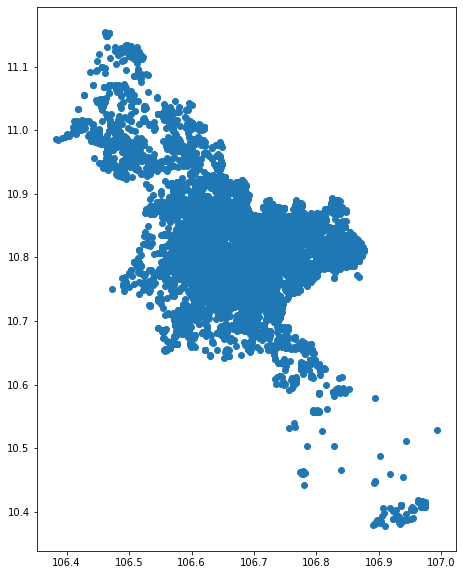

In [ ]:
data_click.plot(figsize=(10,10));

##Bước 7: chạy KMean cho tập các điểm thuộc lần lượt các top 10 quận huyện này.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
def kmeans(data_frame, par1, par2='geometry', n_clusters=20):
    table = data_frame[data_frame.Dist_Name == par1]
    kmeans = KMeans(n_clusters) 
    x = pd.Series(table[par2].apply(lambda p: p.x)) 
    y = pd.Series(table[par2].apply(lambda p: p.y)) 
    point = np.column_stack((x, y)) 
    y_means = kmeans.fit_predict(point) 
    table['cluster'] = y_means 
    return table

In [ ]:
district_1 = kmeans(click_top10, 'District 9', 'geometry', 20);
district_2 = kmeans(click_top10, 'Hoc Mon', 'geometry', 20);
district_3 = kmeans(click_top10, 'Nha Be', 'geometry', 20)
district_4 = kmeans(click_top10, 'District 12', 'geometry', 20);
district_5 = kmeans(click_top10, 'District 2', 'geometry', 20);
district_6 = kmeans(click_top10, 'Cu Chi', 'geometry', 20);
district_7 = kmeans(click_top10, 'District 7', 'geometry', 20);
district_8 = kmeans(click_top10, 'Thu Duc', 'geometry', 20);
district_9 = kmeans(click_top10, 'Binh Chanh', 'geometry', 20);
district_10 = kmeans(click_top10, 'Binh Tan', 'geometry', 20);

##Buớc 8: Lưu cụm điểm thuộc cluster lớn nhất của mỗi quận huyện

In [ ]:
index_1 = district_1['cluster'].value_counts().idxmax()
index_2 = district_2['cluster'].value_counts().idxmax()
index_3 = district_3['cluster'].value_counts().idxmax()
index_4 = district_4['cluster'].value_counts().idxmax()
index_5 = district_5['cluster'].value_counts().idxmax()
index_6 = district_6['cluster'].value_counts().idxmax()
index_7 = district_7['cluster'].value_counts().idxmax()
index_8 = district_8['cluster'].value_counts().idxmax()
index_9 = district_9['cluster'].value_counts().idxmax()
index_10 = district_10['cluster'].value_counts().idxmax()

In [ ]:
cluster_data = dict()
cluster_data['District 9'] = district_1.where(district_1['cluster'] == index_1).dropna()
cluster_data['Hoc Mon'] = district_2.where(district_2['cluster'] == index_2).dropna()
cluster_data['Nha Be'] = district_3.where(district_3['cluster'] == index_3).dropna()
cluster_data['District 12'] = district_4.where(district_4['cluster'] == index_4).dropna()
cluster_data['District 2'] = district_5.where(district_5['cluster'] == index_5).dropna()
cluster_data['Cu Chi'] = district_6.where(district_6['cluster'] == index_6).dropna()
cluster_data['District 7'] = district_7.where(district_7['cluster'] == index_7).dropna()
cluster_data['Thu Duc'] = district_8.where(district_8['cluster'] == index_8).dropna()
cluster_data['Binh Chanh'] = district_9.where(district_9['cluster'] == index_9).dropna()
cluster_data['Binh Tan'] = district_10.where(district_10['cluster'] == index_10).dropna()

In [ ]:
cluster_data['Binh Tan']

,FID,dbh,geometry,index_right,Dist_Name,Dist_ID,Level,Pop_2009,Pop_2010,Pop_2011,Pop_2012,Pop_2013,Pop_2014,Pop_2015,Pop_2016,Pop_2017,Pop_2019,Den_2009,Den_2010,Den_2011,Den_2012,Den_2013,Den_2014,Den_2015,Den_2016,Den_2017,Den_2019,Shape_Leng,Shape_Area,Pop2019/Pop2017,cluster
72,72.0,1.0,POINT (106.60847 10.78547),12.0,Binh Tan,777,District,572132.0,595335.0,616777.0,639088.0,655244.0,672309.0,686474.0,704347.0,729366.0,784173.0,11020.8,11467.7,11880.8,12310.5,12621.8,12950.5,13223.3,13567.6,14049.5,15105.3,40057.584063,5.191097e+07,1.075143,4.0
266,266.0,1.0,POINT (106.60651 10.78572),12.0,Binh Tan,777,District,572132.0,595335.0,616777.0,639088.0,655244.0,672309.0,686474.0,704347.0,729366.0,784173.0,11020.8,11467.7,11880.8,12310.5,12621.8,12950.5,13223.3,13567.6,14049.5,15105.3,40057.584063,5.191097e+07,1.075143,4.0
306,306.0,1.0,POINT (106.60625 10.78620),12.0,Binh Tan,777,District,572132.0,595335.0,616777.0,639088.0,655244.0,672309.0,686474.0,704347.0,729366.0,784173.0,11020.8,11467.7,11880.8,12310.5,12621.8,12950.5,13223.3,13567.6,14049.5,15105.3,40057.584063,5.191097e+07,1.075143,4.0
546,546.0,1.0,POINT (106.61535 10.79087),12.0,Binh Tan,777,District,572132.0,595335.0,616777.0,639088.0,655244.0,672309.0,686474.0,704347.0,729366.0,784173.0,11020.8,11467.7,11880.8,12310.5,12621.8,12950.5,13223.3,13567.6,14049.5,15105.3,40057.584063,5.191097e+07,1.075143,4.0
547,547.0,1.0,POINT (106.60719 10.79008),12.0,Binh Tan,777,District,572132.0,595335.0,616777.0,639088.0,655244.0,672309.0,686474.0,704347.0,729366.0,784173.0,11020.8,11467.7,11880.8,12310.5,12621.8,12950.5,13223.3,13567.6,14049.5,15105.3,40057.584063,5.191097e+07,1.075143,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27103,27103.0,1.0,POINT (106.60738 10.78524),12.0,Binh Tan,777,District,572132.0,595335.0,616777.0,639088.0,655244.0,672309.0,686474.0,704347.0,729366.0,784173.0,11020.8,11467.7,11880.8,12310.5,12621.8,12950.5,13223.3,13567.6,14049.5,15105.3,40057.584063,5.191097e+07,1.075143,4.0
27373,27373.0,1.0,POINT (106.60735 10.78517),12.0,Binh Tan,777,District,572132.0,595335.0,616777.0,639088.0,655244.0,672309.0,686474.0,704347.0,729366.0,784173.0,11020.8,11467.7,11880.8,12310.5,12621.8,12950.5,13223.3,13567.6,14049.5,15105.3,40057.584063,5.191097e+07,1.075143,4.0
27425,27425.0,1.0,POINT (106.60680 10.78535),12.0,Binh Tan,777,District,572132.0,595335.0,616777.0,639088.0,655244.0,672309.0,686474.0,704347.0,729366.0,784173.0,11020.8,11467.7,11880.8,12310.5,12621.8,12950.5,13223.3,13567.6,14049.5,15105.3,40057.584063,5.191097e+07,1.075143,4.0
27454,27454.0,1.0,POINT (106.60752 10.78584),12.0,Binh Tan,777,District,572132.0,595335.0,616777.0,639088.0,655244.0,672309.0,686474.0,704347.0,729366.0,784173.0,11020.8,11467.7,11880.8,12310.5,12621.8,12950.5,13223.3,13567.6,14049.5,15105.3,40057.584063,5.191097e+07,1.075143,4.0


##Bước 9: Show lên bản đồ các cụm đông nhất theo từng quận huyện theo dạng HEATMAP

In [ ]:
data = []
for clu in cluster_data.values():
  x = pd.Series(clu['geometry'].apply(lambda p: p.x)) 
  y = pd.Series(clu['geometry'].apply(lambda p: p.y))
  point = np.column_stack((y, x)) 
  data = data + point.tolist()

In [ ]:
from glob import glob
from folium import plugins
from folium.plugins import HeatMap

map = folium.Map([10.8, 106.7], tiles='CartoDB positron', zoom_start=10)
HeatMap(data).add_to(map)

for _, r in data_10.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['Dist_Name']).add_to(geo_j)
    geo_j.add_to(map)
map

HeatMap(data).add_to(map);

In [ ]:
map

## Bước 10: Lưu heatmap xuống file png

In [ ]:
!apt-get update 
!apt install chromium-chromedriver

In [ ]:
pip install selenium

In [38]:
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: use options instead of chrome_options
  


In [39]:
import os
map_path='MAP.html'
map.save(map_path)
map_URL='file://{path}/{mapfile}'.format(path=os.getcwd(), mapfile=map_path)

driver.get(map_URL)

driver.save_screenshot('map.png')
driver.quit()